In [32]:

import utils
from Gian_experimental.NSGAIICustom.evolving_genome_threshold import NCSolutionWithGT
from Core.SearchSpace import SearchSpace
from Core.PRef import PRef
from Gian_experimental.NSGAIICustom.testing_in_vitro.SPRef import OptimisedSPref
import json
import numpy as np

temp_vector_path = r"C:\Users\gac8\PycharmProjects\PSSearch\retail_forecasting_data_collection\data\many_hot_vectors_250_random.csv"
temp_fitness_path = r"C:\Users\gac8\PycharmProjects\PSSearch\retail_forecasting_data_collection\data\fitness_250_random.csv"

all_vectors = np.loadtxt(temp_vector_path, delimiter=",", dtype=int)

# fitnesses_for_GA, hits_20, hits_100 = np.genfromtxt(temp_fitness_path, delimiter=",", dtype=float, usecols=(2, 4, 5))
fitnesses_for_GA, hits_100, hits_20 = np.genfromtxt(temp_fitness_path, delimiter=",", dtype=float, usecols=(2, 4, 6)).T

print("column 2, expected to be normal fitnesses ", fitnesses_for_GA)
print(f"column 4, expected to be HR 100 (high average = {np.average(hits_100):.3f})", hits_100)
print(f"column 6, expected to be HR 20 (low average = {np.average(hits_20):.3f})", hits_20)


train_test_partitions_by_seed_path = r"C:\Users\gac8\PycharmProjects\PSSearch\retail_forecasting_data_collection\data\test_indices.json"
train_test_partitions_by_seed = json.load(open(train_test_partitions_by_seed_path, "r"))

print(f"We have partitions for {len(train_test_partitions_by_seed)} seeds")


def construct_temp_spRef(which: str, seed: int) -> OptimisedSPref:
    # we make a pRef which is optimised (we represent a session as the set of the variables that are ones)
    # the fitnesses in this pRef are just the index of their row [0, 1, 2,  ...]
    
    # this allows to get any fitness we want without having to make a lot of slow code!
    
    test_indices = train_test_partitions_by_seed[str(seed)]
    if which == "test":
        row_indices = test_indices
    else:
        row_indices = list(set(range(len(all_vectors))) - set(test_indices))
        
    vectors = all_vectors[row_indices]
    trad_pRef = PRef(fitness_array=np.array(row_indices),
                           full_solution_matrix=vectors,
                           search_space=SearchSpace([2 for _ in range(250)]))
    
    sPRef = OptimisedSPref.from_pRef(trad_pRef)
    del trad_pRef
    
    return sPRef


def get_info_for_individual_ps(ps: NCSolutionWithGT, temp_test_spRef, temp_train_spRef):
    matched_test_indices, unmatched_test_indices = temp_test_spRef.partition(ps, threshold=ps.genome_threshold)
    
    matched_train_indices, unmatched_train_indices = temp_train_spRef.partition(ps, threshold=ps.genome_threshold)
    
    average_test_HR_20 = np.average(hits_20[matched_test_indices])
    average_test_HR_100 = np.average(hits_100[matched_test_indices])
    univ_test = len(matched_test_indices) / (len(matched_test_indices) + len(unmatched_test_indices))
    
    average_train_HR_20 = np.average(hits_20[matched_train_indices])
    average_train_HR_100 = np.average(hits_100[matched_train_indices])
    univ_train = len(matched_train_indices) / (len(matched_train_indices) + len(unmatched_train_indices))
    
    return univ_test, average_test_HR_20, average_test_HR_100, univ_train, average_train_HR_20, average_train_HR_100
    


column 2, expected to be normal fitnesses  [11.18746567 17.32204247  9.72239876 ...  6.85158873  8.78421211
 10.7397728 ]
column 4, expected to be HR 100 (high average = 0.547) [1. 1. 1. ... 0. 1. 1.]
column 6, expected to be HR 20 (low average = 0.245) [1. 1. 0. ... 0. 1. 1.]
We have partitions for 100 seeds


We will parse some json files in a folder, and we want to make a dataframe with the columns:
* code_name (a string)
* length (an int)
* genome_threshold (an int)
* test_coverage
* test_HR_20
* test_HR_100
* train_coverage
* train_HR_20
* train_HR_100

For every file in results_folder that ends in ".json":
* let seed = data["seed"]
* let test_sessions = construct_temp_spRef(which = "test", seed=seed)
* let train_sessions = construct_temp_spRef(which = "train", seed=seed)
* read data["data"], which contains many runs with different settings. Iterate over each run
    * each run has a code_name, read it in run["config"]["code_name"]
    * each run has a set of produced outputs, under run["results"]
        * for each output, let ps = NCSolutionWithGT(values = set(output["pattern"], genome_threshold = output["threshold"]
        * then let length = len(ps)
        * genome_threshold = ps.genome_threshold
        * test_coverage, ..., train_HR_100  = get_info_for_individual_ps(ps, test_sessions, train_sessions)
        * put the relevant information as a row in the dataframe mentioned in the beginning


In [33]:
from tqdm import tqdm
import os
import json
import pandas as pd


def process_results_folder(results_folder):
    rows = []

    for filename in os.listdir(results_folder):
        print("processing file ", filename)
        if not filename.endswith(".json"):
            continue

        filepath = os.path.join(results_folder, filename)
        with open(filepath, 'r') as f:
            data = json.load(f)

        seed = data["extra_info"]["seed"]
        test_sessions = construct_temp_spRef(which="test", seed=seed)
        train_sessions = construct_temp_spRef(which="train", seed=seed)

        for run in data["data"]:
            code_name = run["config"]["code_name"]
            for output in tqdm(run["results"]):
                ps = NCSolutionWithGT(
                    values=set(output["pattern"]),
                    genome_threshold=output["threshold"]
                )
                length = len(ps)
                genome_threshold = ps.genome_threshold

                (
                    test_coverage,
                    test_HR_20,
                    test_HR_100,
                    train_coverage,
                    train_HR_20,
                    train_HR_100
                ) = get_info_for_individual_ps(ps, test_sessions, train_sessions)

                row = {
                    "code_name": code_name,
                    "length": length,
                    "genome_threshold": genome_threshold,
                    "test_coverage": test_coverage,
                    "test_HR_20": test_HR_20,
                    "test_HR_100": test_HR_100,
                    "train_coverage": train_coverage,
                    "train_HR_20": train_HR_20,
                    "train_HR_100": train_HR_100,
                }

                rows.append(row)

    return pd.DataFrame(rows)

# Usage
# df = process_results_folder("path/to/results_folder")
# print(df.head())


In [39]:
results_folder = r"C:\Users\gac8\PycharmProjects\PSSearch\retail_forecasting_data_collection\local_results_without_gt"
results_df = process_results_folder(results_folder)

display(results_df)

processing file  result_06-27-H10'm'20's43.json


100%|██████████| 56/56 [00:00<00:00, 431.30it/s]


processing file  result_06-27-H10'm'37's43.json


100%|██████████| 57/57 [00:00<00:00, 474.37it/s]


processing file  result_06-27-H10'm'54's37.json


100%|██████████| 44/44 [00:00<00:00, 422.69it/s]


,code_name,length,genome_threshold,test_coverage,test_HR_20,test_HR_100,train_coverage,train_HR_20,train_HR_100
0,[CS CM CC][Len SSize MFit CAtom][GNone],2,None,0.057091,0.289517,0.668885,0.056825,0.296281,0.653991
1,[CS CM CC][Len SSize MFit CAtom][GNone],2,None,0.021849,0.286957,0.552174,0.024197,0.271835,0.580962
2,[CS CM CC][Len SSize MFit CAtom][GNone],2,None,0.026788,0.322695,0.652482,0.026216,0.378623,0.709239
3,[CS CM CC][Len SSize MFit CAtom][GNone],2,None,0.025173,0.350943,0.743396,0.026999,0.338610,0.693931
4,[CS CM CC][Len SSize MFit CAtom][GNone],2,None,0.038567,0.290640,0.605911,0.042434,0.259653,0.578623
...,...,...,...,...,...,...,...,...,...
910,[CS CM OC][Len SSize MFit CAtom][GNone],2,None,0.026788,0.304965,0.595745,0.026952,0.329515,0.644053
911,[CS CM OC][Len SSize MFit CAtom][GNone],2,None,0.138216,0.298969,0.659794,0.146467,0.300746,0.640402
912,[CS CM OC][Len SSize MFit CAtom][GNone],1,None,0.245939,0.265353,0.598687,0.248765,0.274055,0.588393
913,[CS CM OC][Len SSize MFit CAtom][GNone],2,None,0.033723,0.273239,0.571831,0.032176,0.290775,0.602214


In [40]:
import utils

scratch_path = r"C:\Users\gac8\PycharmProjects\PSSearch\retail_forecasting_data_collection\scratch_processing\processed"+utils.get_formatted_timestamp()+".csv"


results_df.to_csv(scratch_path)

Code name: [CS CM CC][Len MFit CAtom][G3]


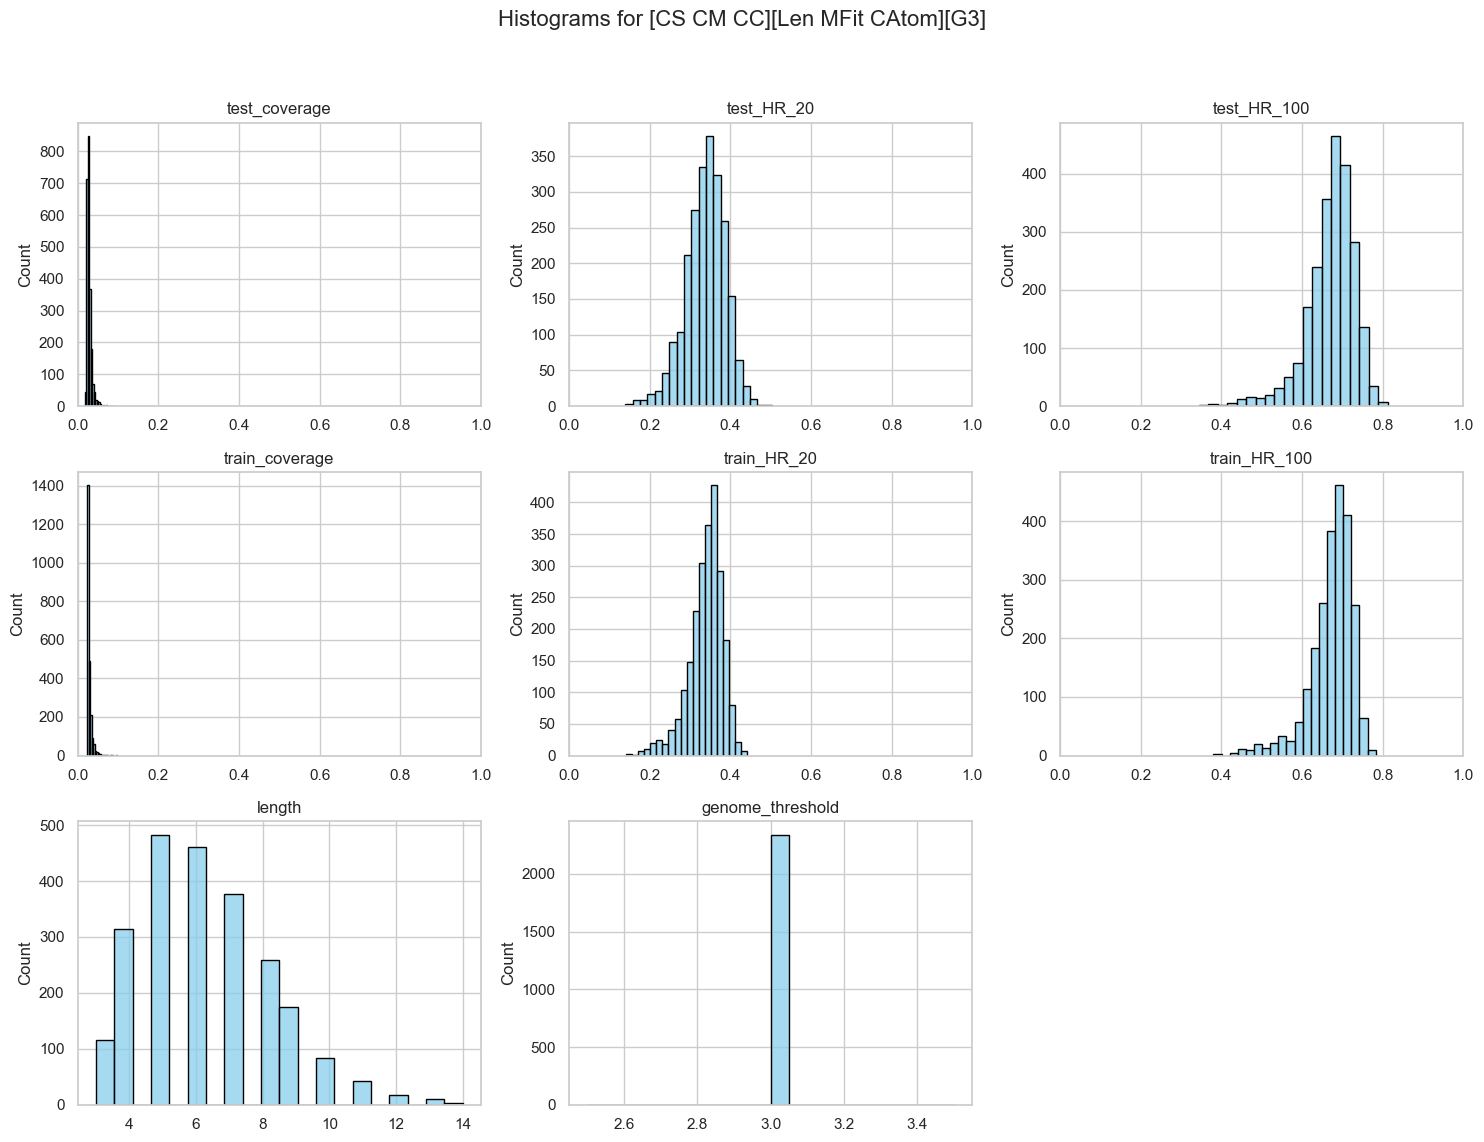

Code name: [CS CM CC][Len SSize CAtom][G3]


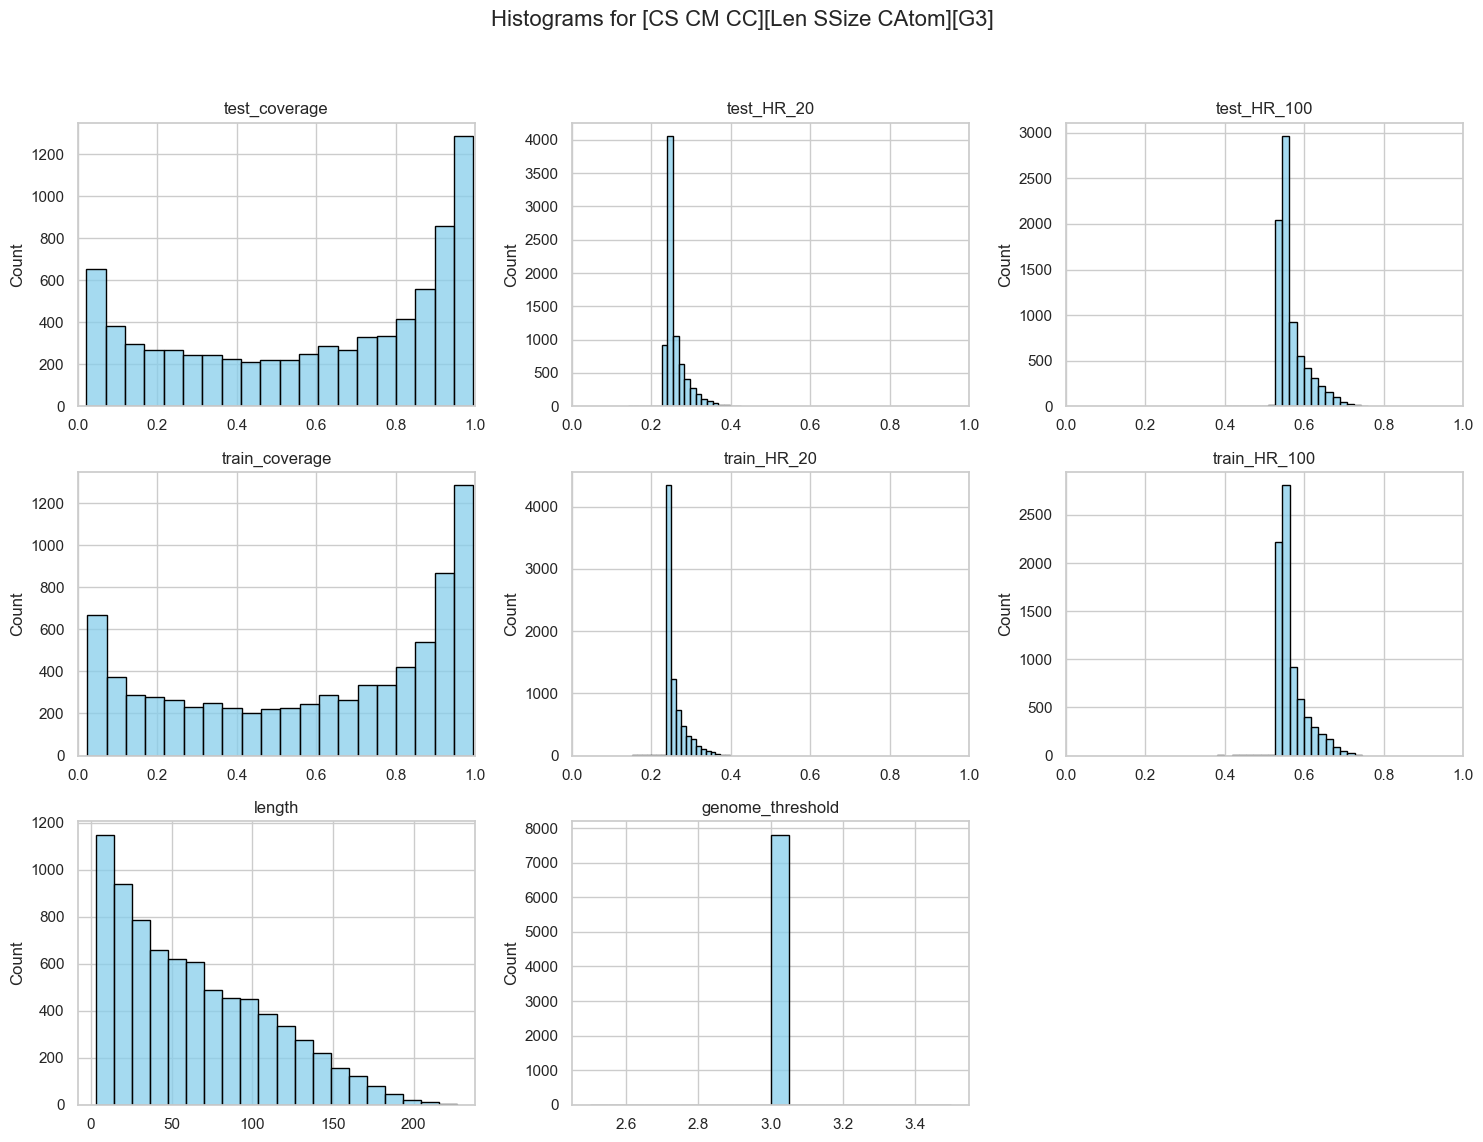

Code name: [CS CM CC][Len SSize MFit CAtom][G3]


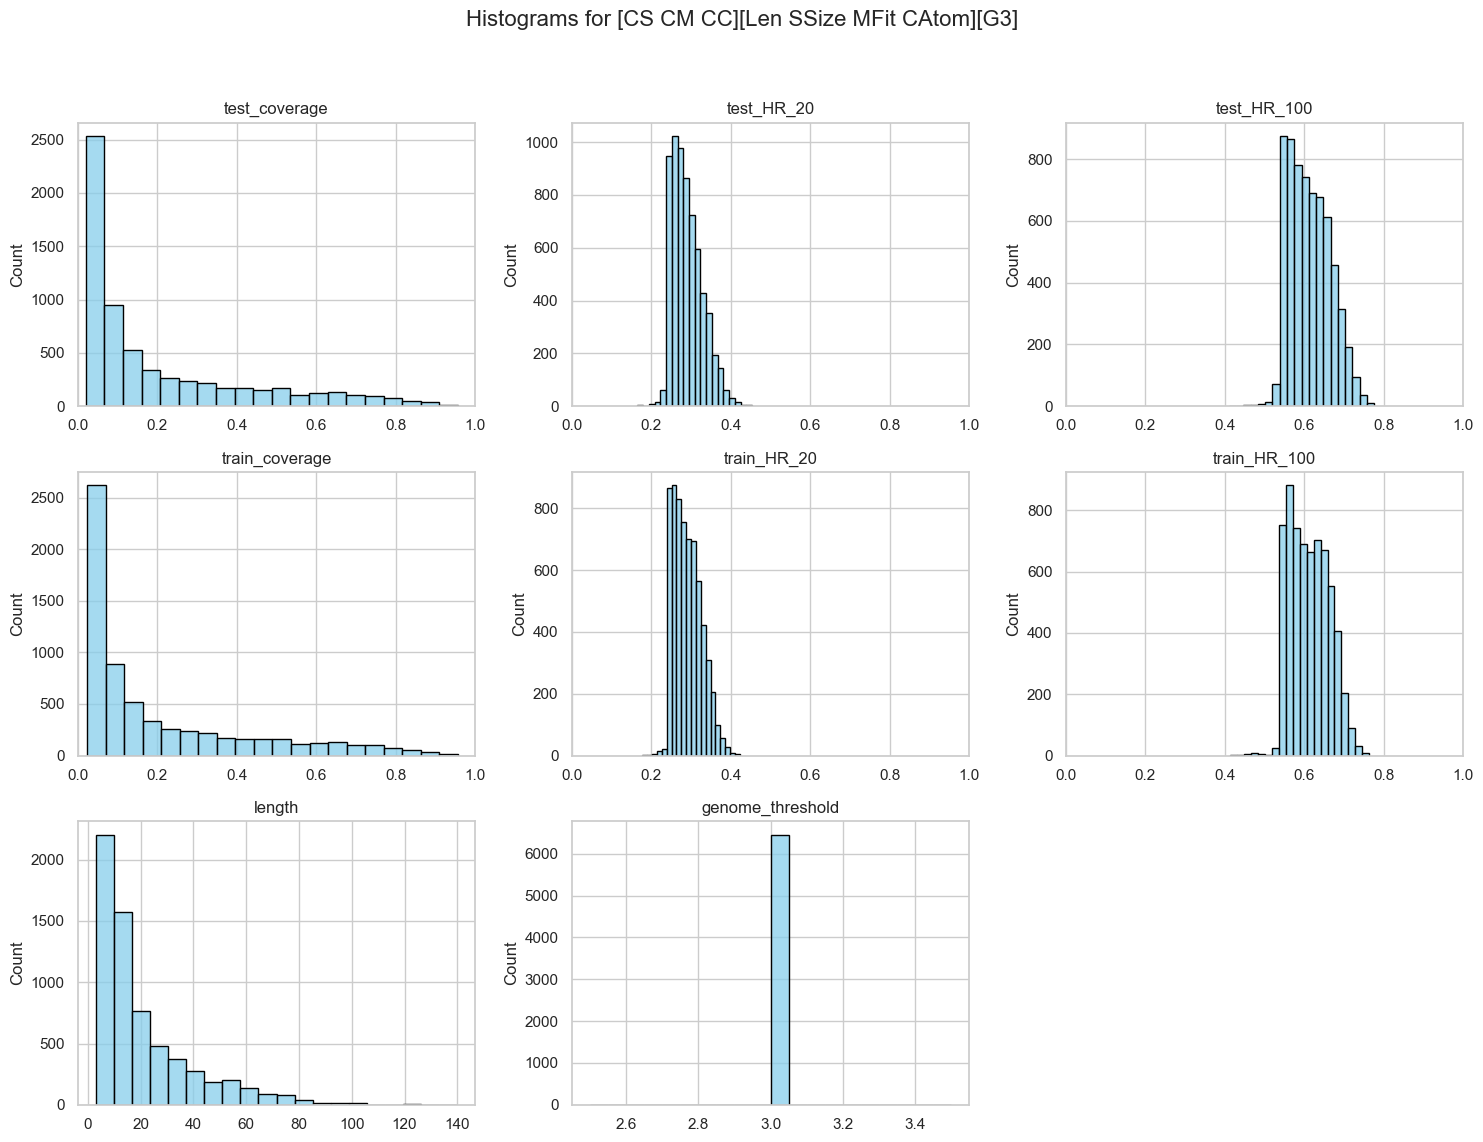

Code name: [CS CM CC][Len SSize MFit CAtom][G4]


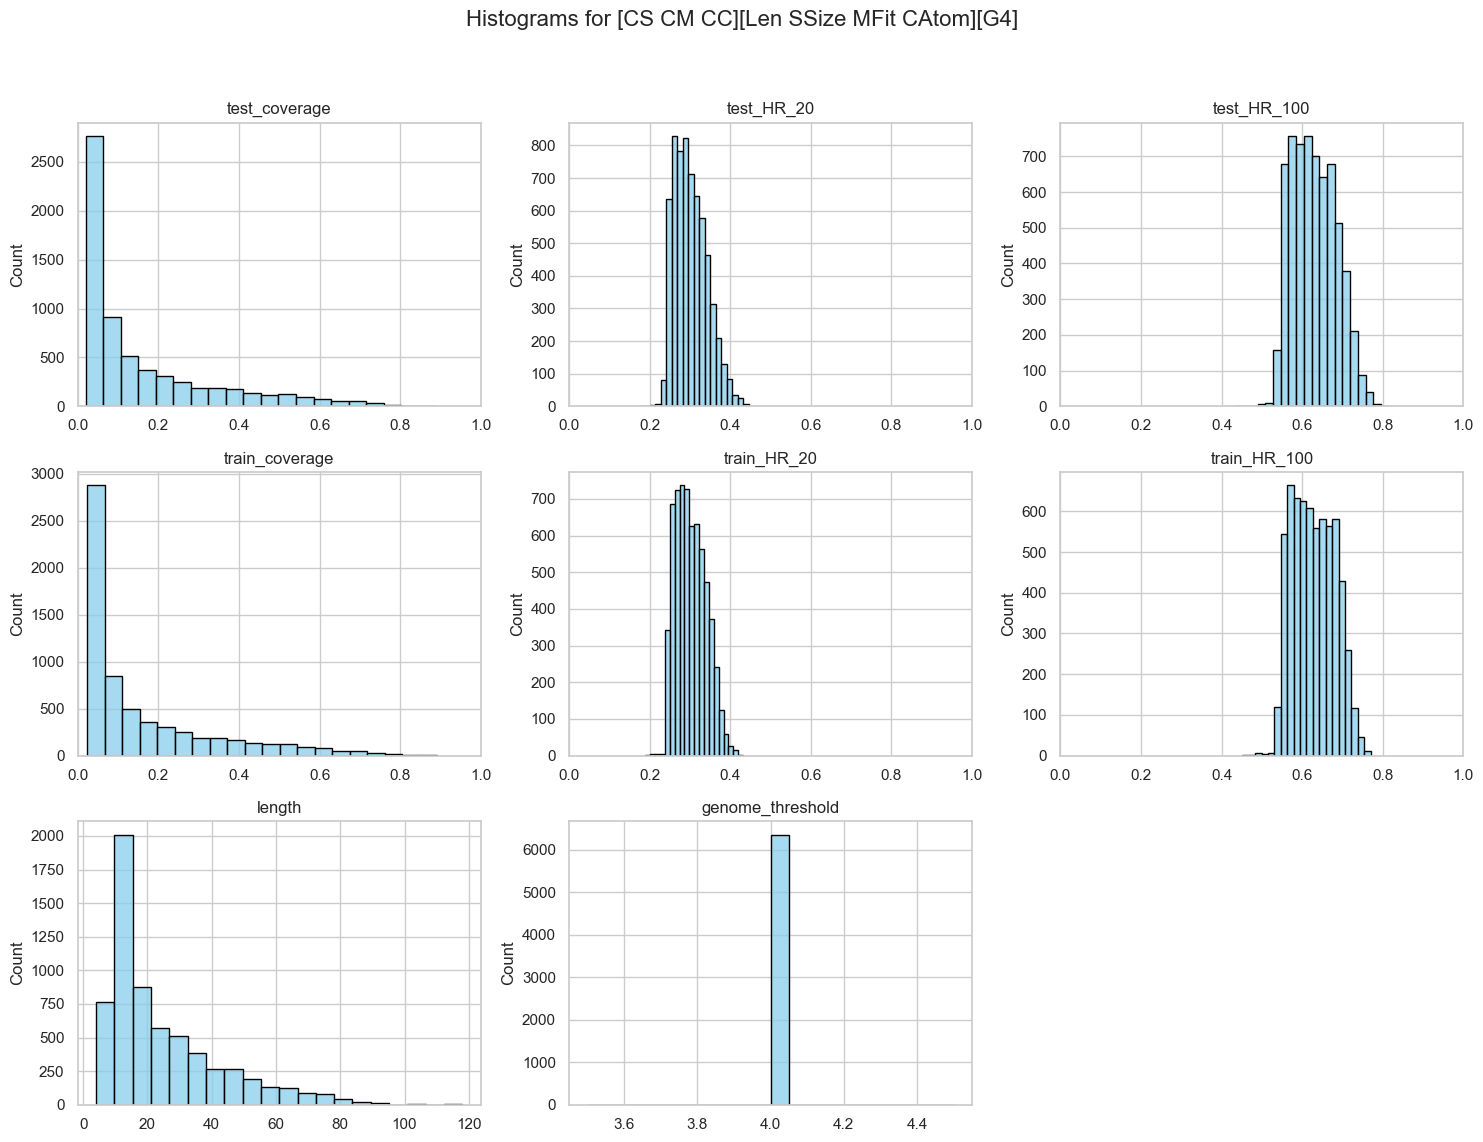

Code name: [CS CM CC][Len SSize MFit CAtom][G5]


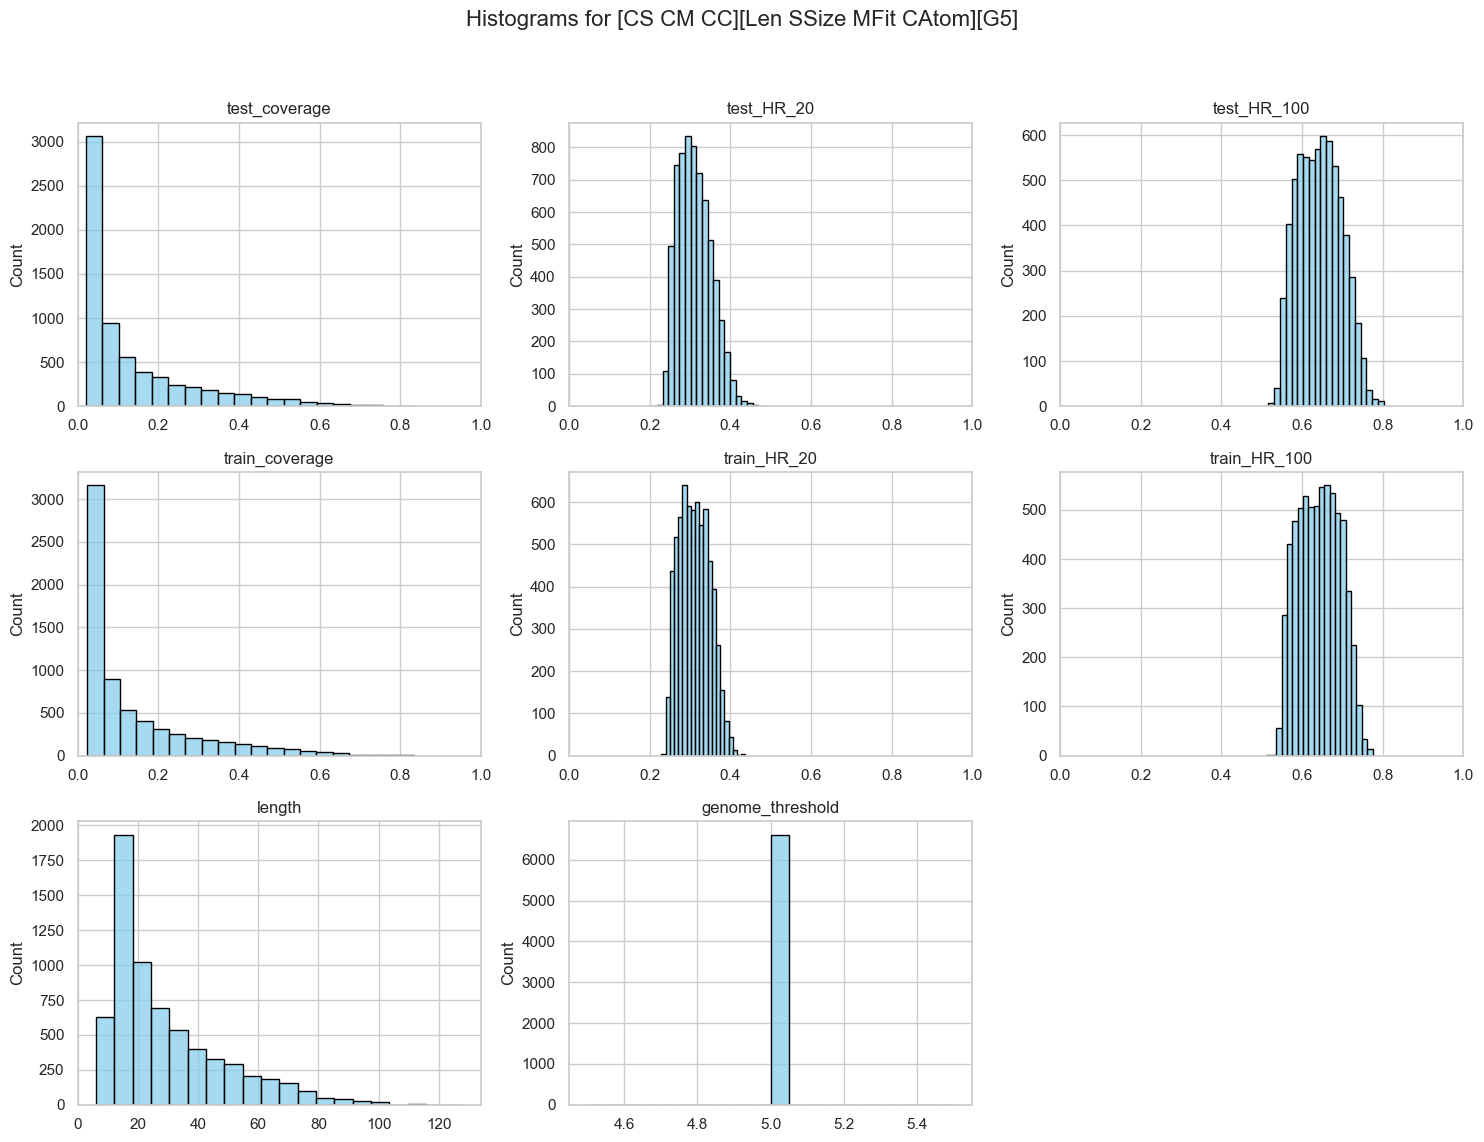

Code name: [CS CM CC][Len SSize MFit CAtom][Gauto]


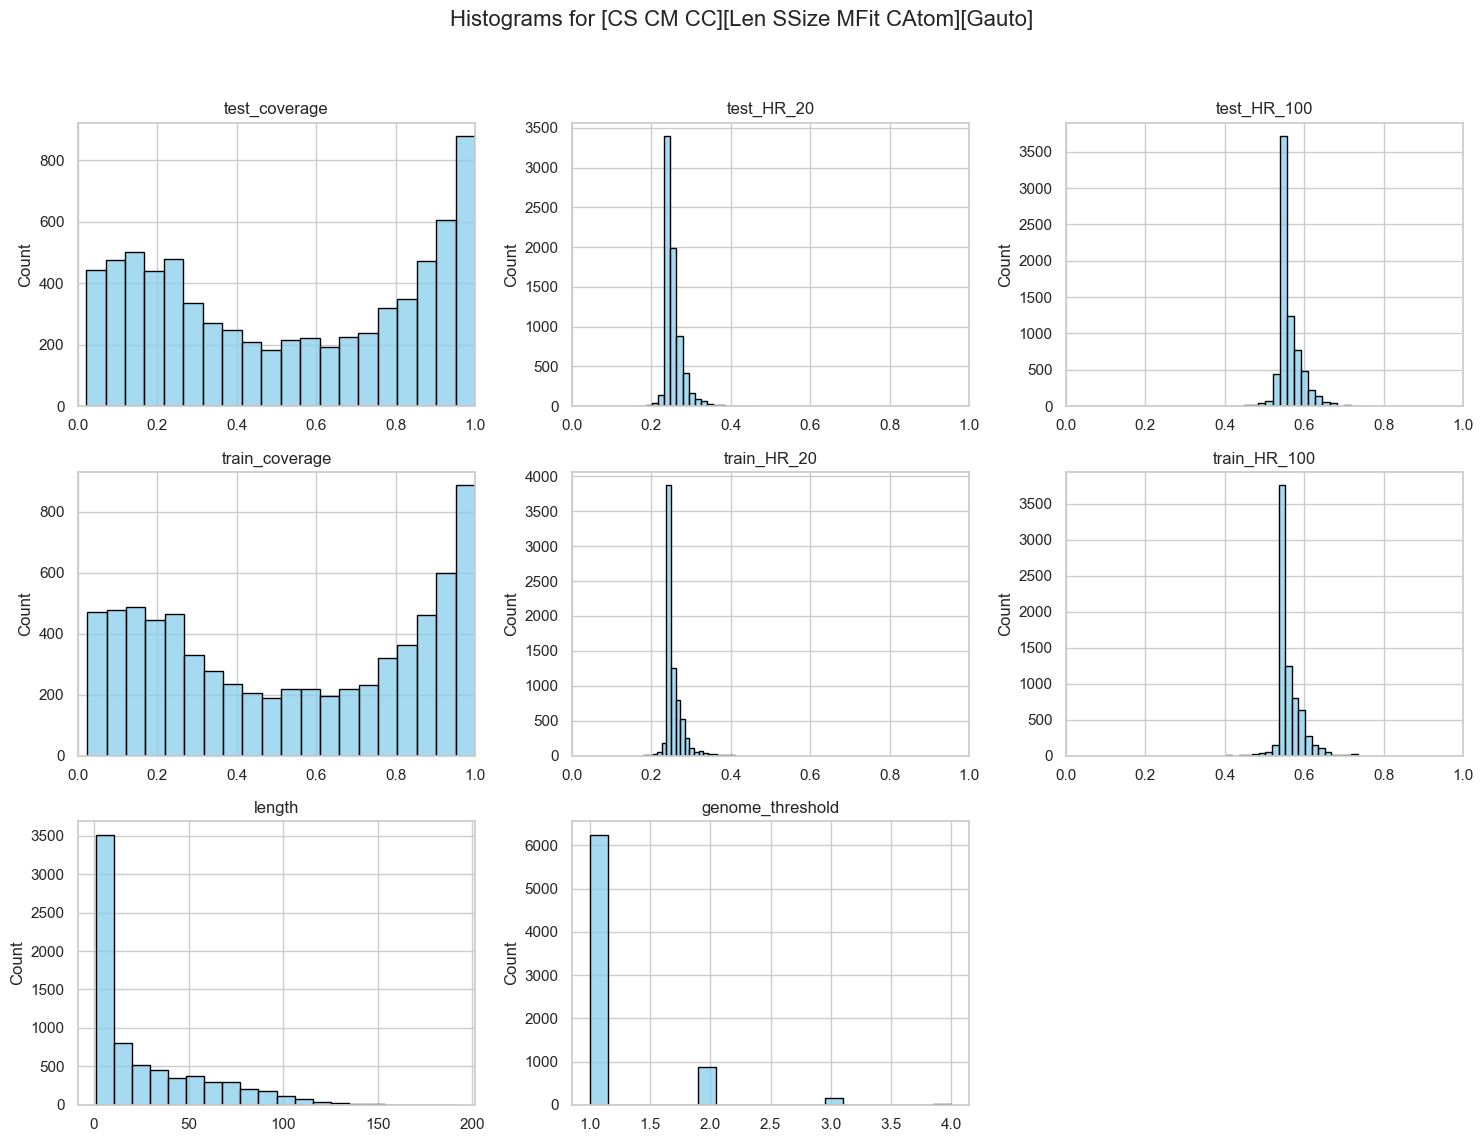

Code name: [CS CM CC][Len SSize MFit][G3]


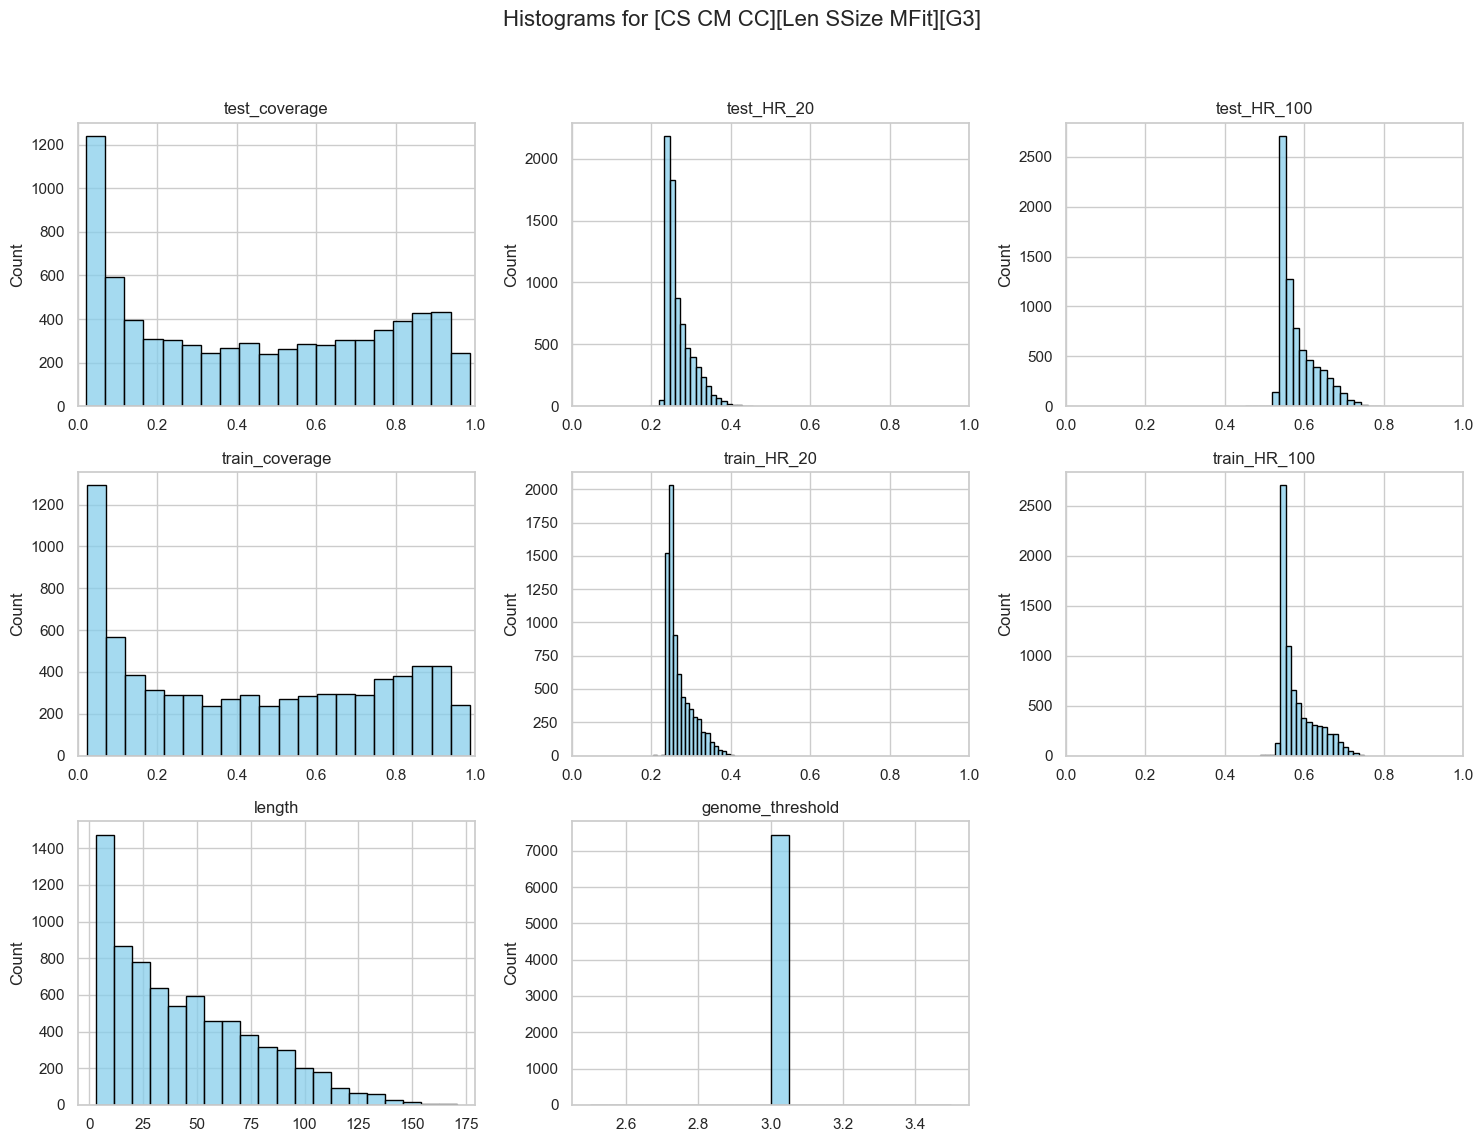

Code name: [CS CM CC][SSize MFit CAtom][G3]


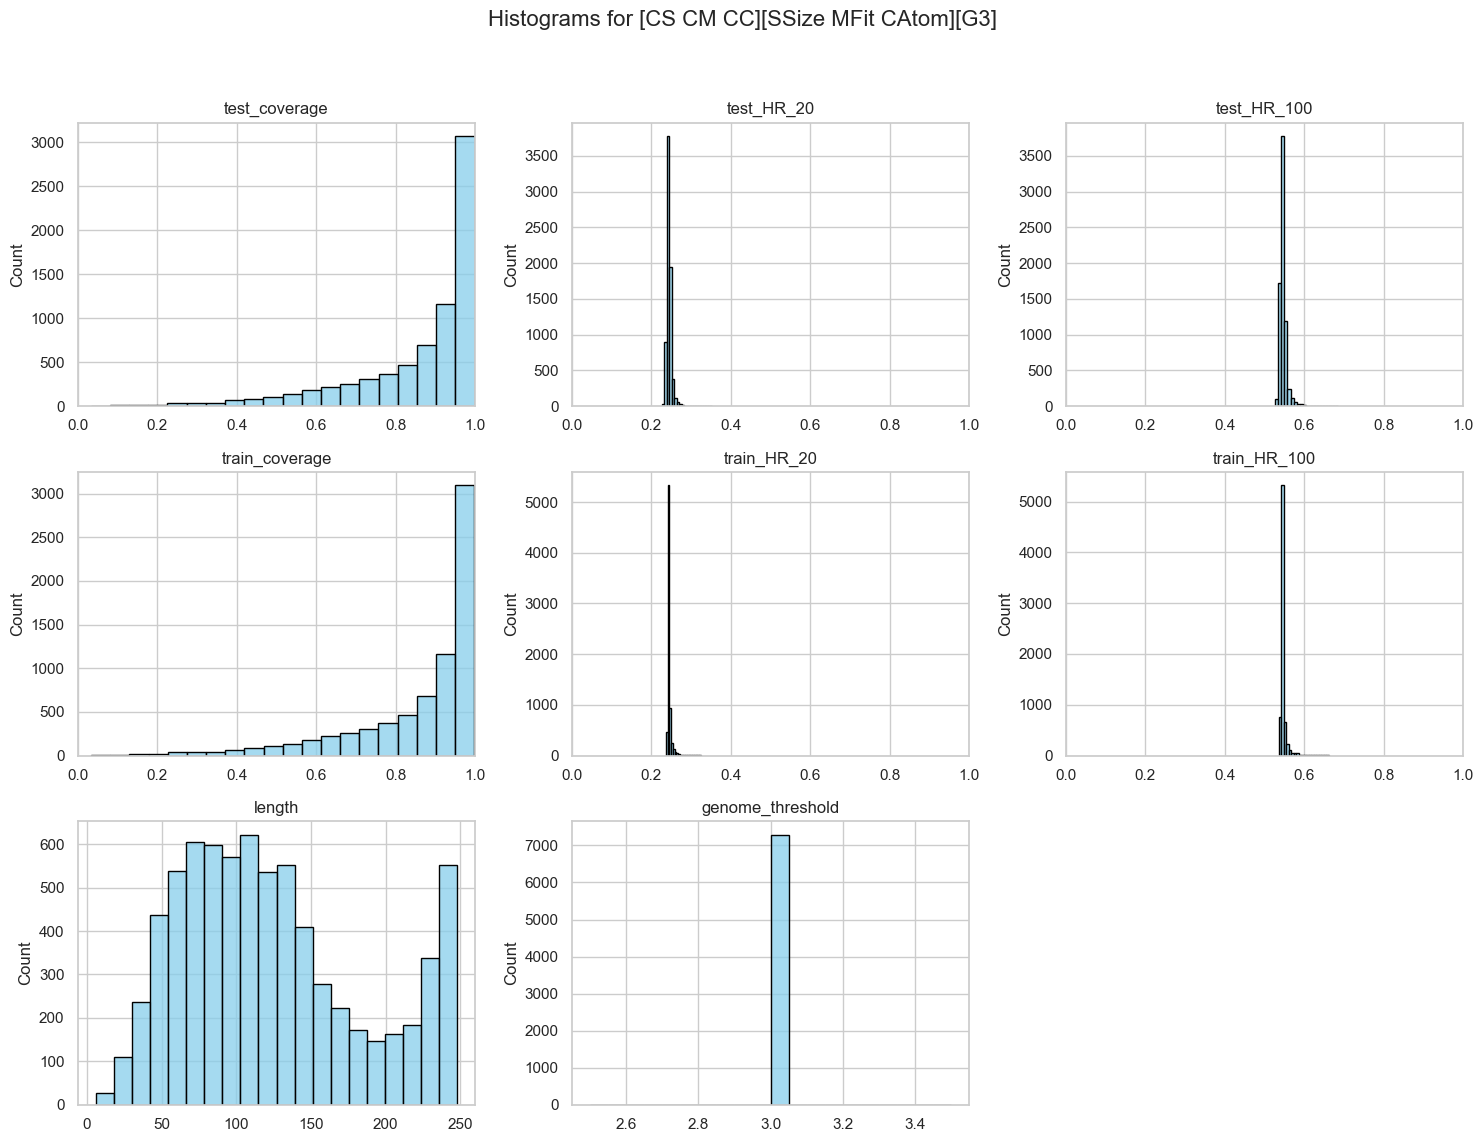

Code name: [CS CM OC][Len SSize MFit CAtom][G3]


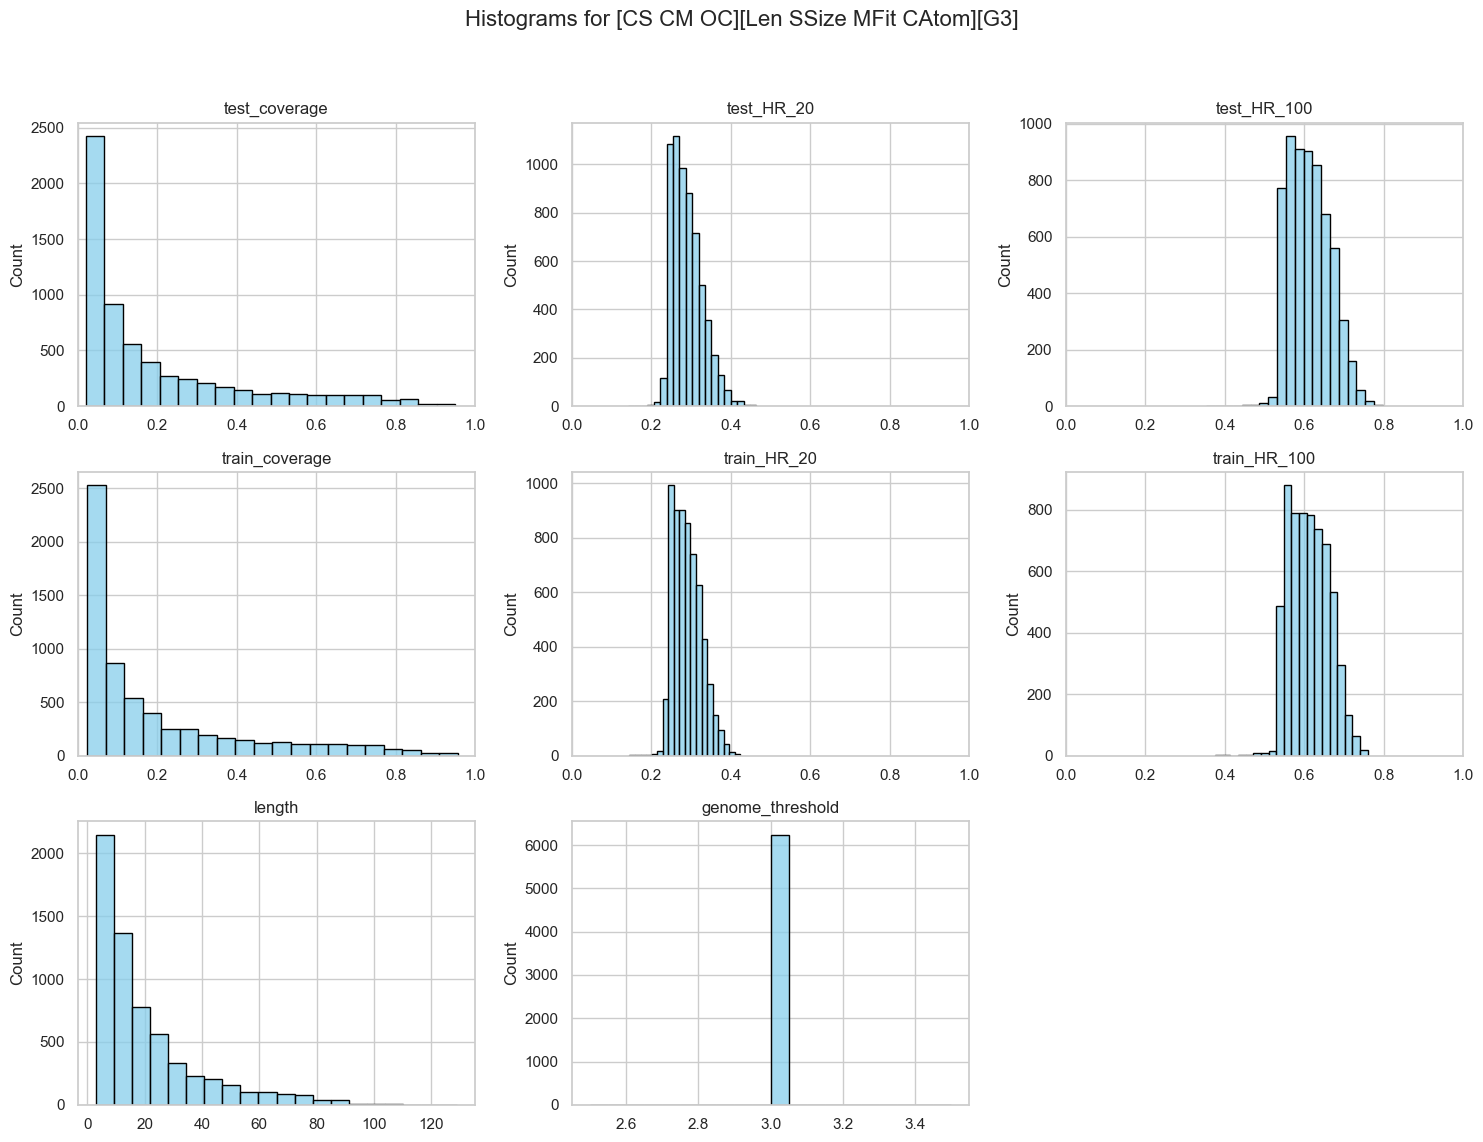

Code name: [CS OM CC][Len SSize MFit CAtom][G3]


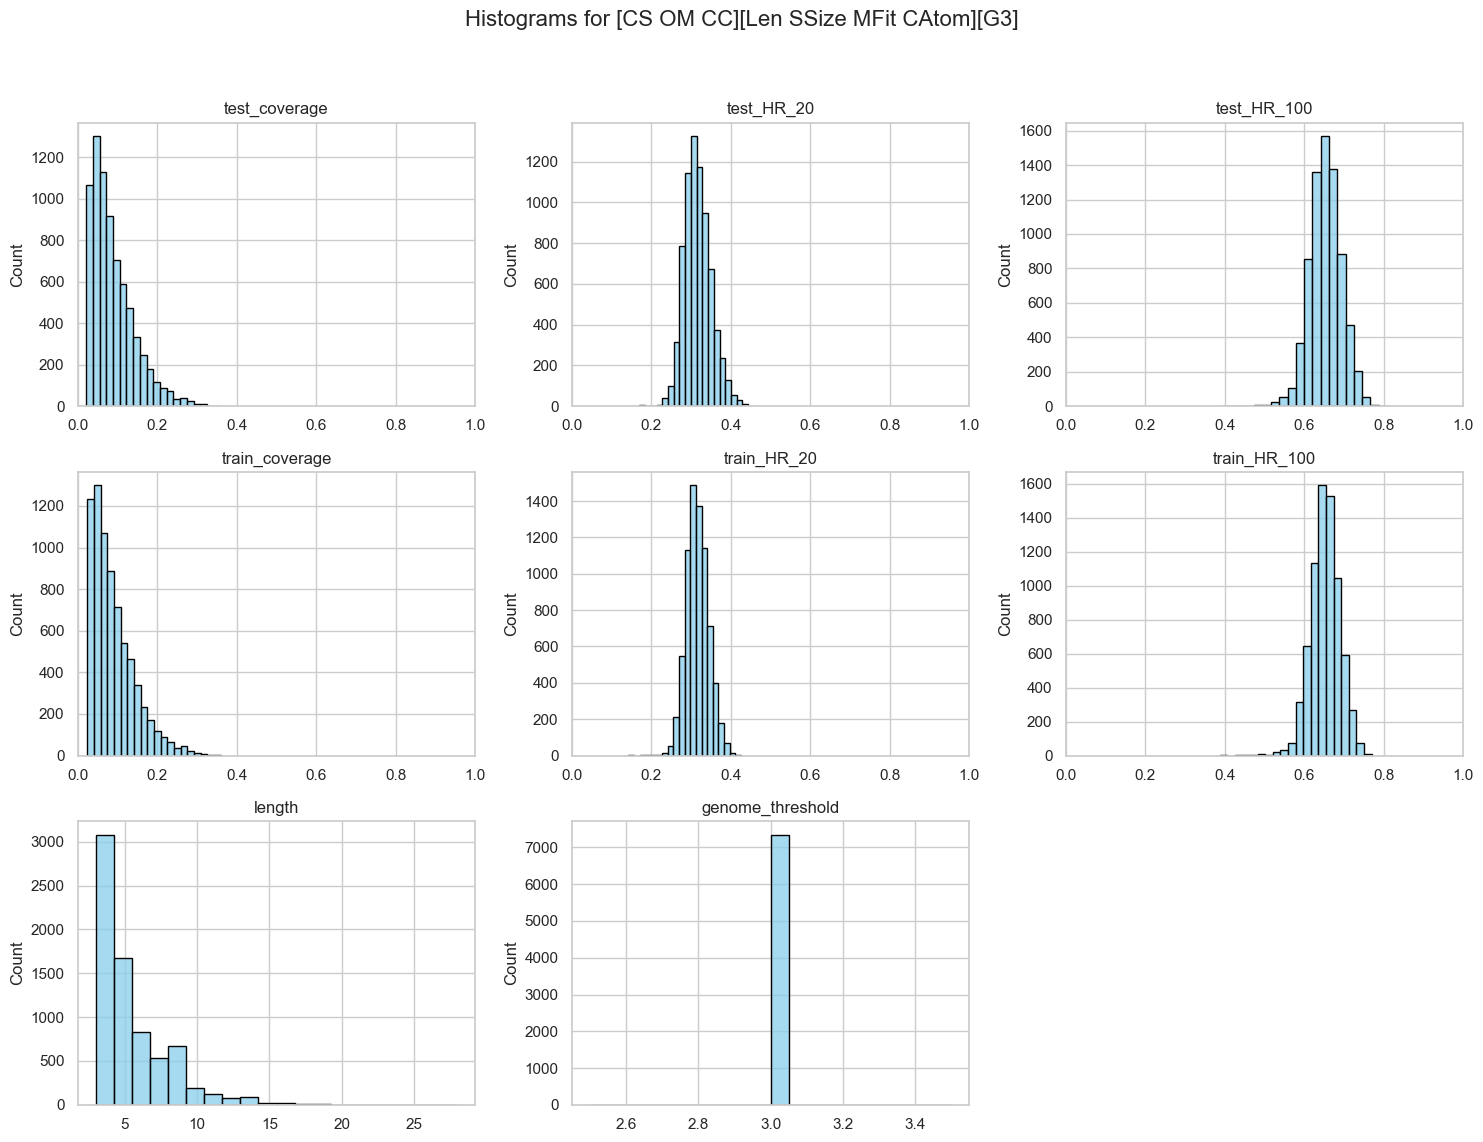

Code name: [OS CM CC][Len SSize MFit CAtom][G3]


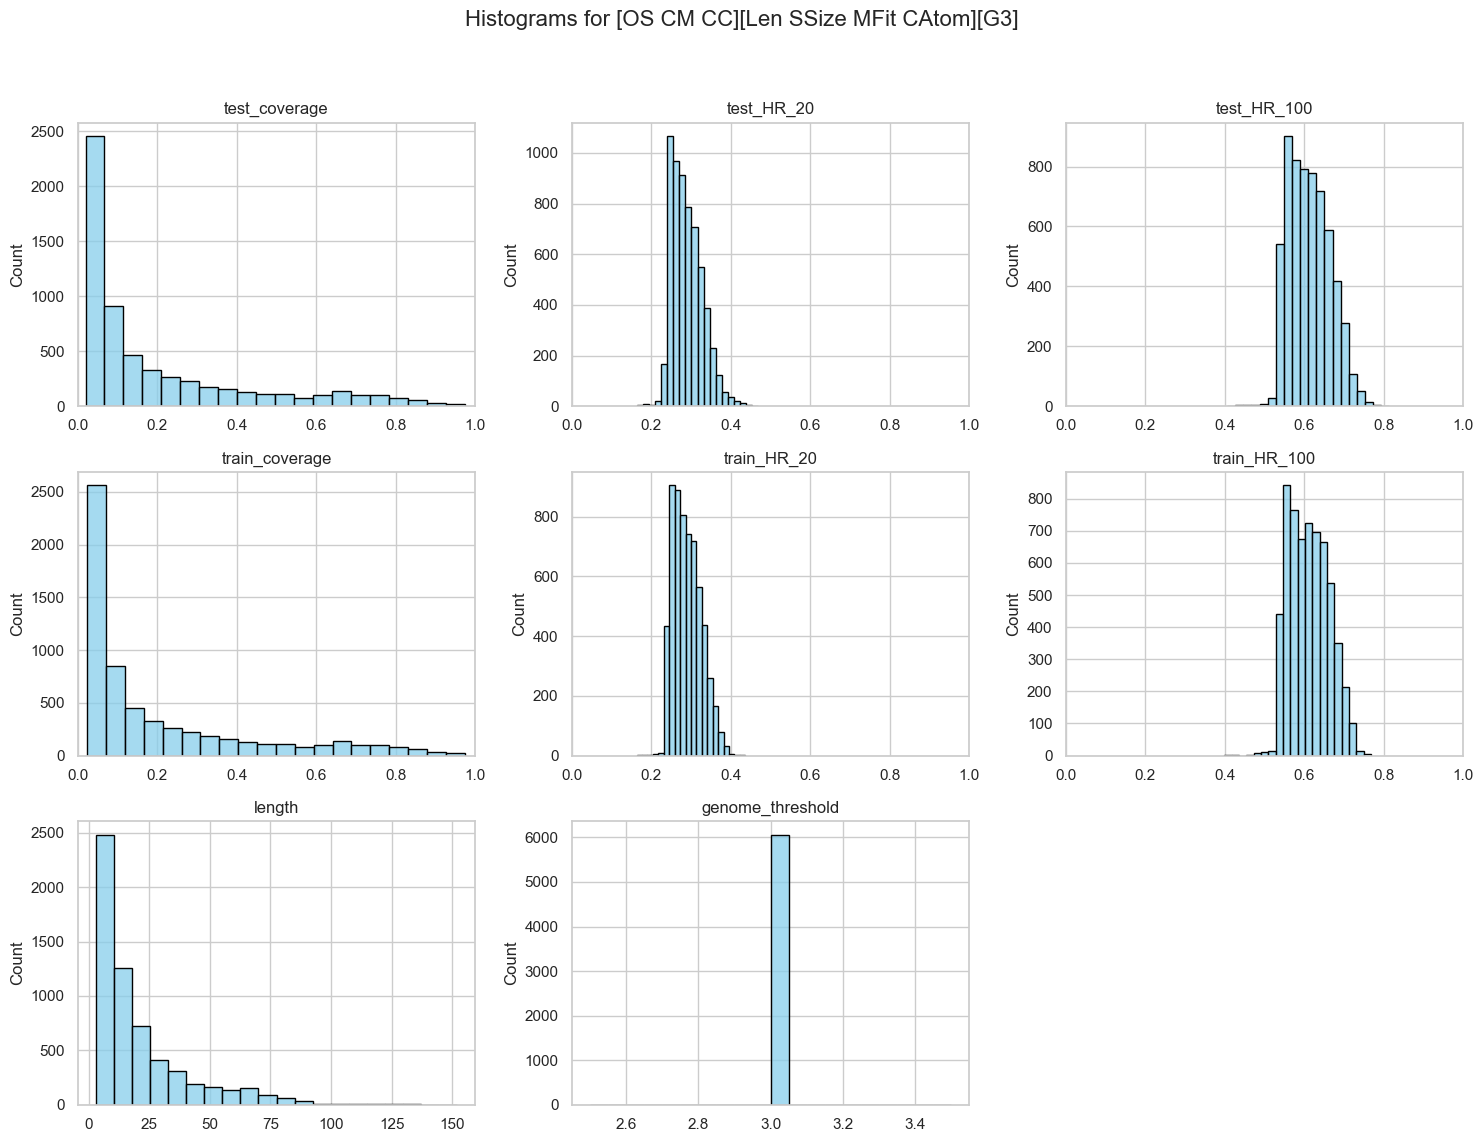

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (6, 4)

# Define metrics in the order you want them shown
metrics = [
    "test_coverage",
    "test_HR_20",
    "test_HR_100",
    "train_coverage",
    "train_HR_20",
    "train_HR_100",
    "length",
    "genome_threshold",
]

# Define which metrics are [0, 1] bounded
bounded_metrics = {
    "test_coverage", "test_HR_20", "test_HR_100",
    "train_coverage", "train_HR_20", "train_HR_100"
}

# Loop through each code_name
for code_name, group_df in results_df.groupby("code_name"):
    print(f"Code name: {code_name}")

    n_metrics = len(metrics)
    n_cols = 3
    # We want test_coverage to start on a new row, so we insert a row break before it
    row_break_index = metrics.index("test_coverage")
    top_half = metrics[:row_break_index]
    bottom_half = metrics[row_break_index:]

    # Total rows = ceil(len(top_half) / n_cols) + ceil(len(bottom_half) / n_cols)
    n_top_rows = -(-len(top_half) // n_cols)
    n_bottom_rows = -(-len(bottom_half) // n_cols)
    total_rows = n_top_rows + n_bottom_rows

    fig, axs = plt.subplots(total_rows, n_cols, figsize=(n_cols * 5, total_rows * 4))
    axs = axs.flatten()

    for i, metric in enumerate(metrics):
        ax = axs[i]
        sns.histplot(group_df[metric], bins=20, kde=False, ax=ax, color="skyblue", edgecolor="black")
        ax.set_title(metric)
        if metric in bounded_metrics:
            ax.set_xlim(0, 1)
        ax.set_xlabel("")
        ax.set_ylabel("Count")

    # Hide any unused subplots
    for j in range(len(metrics), len(axs)):
        axs[j].axis("off")

    plt.suptitle(f"Histograms for {code_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


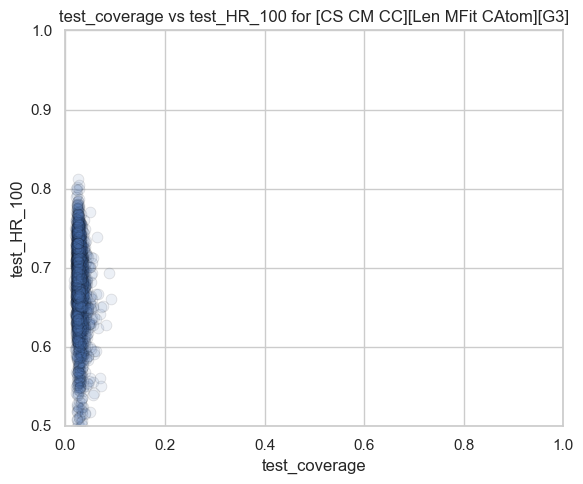

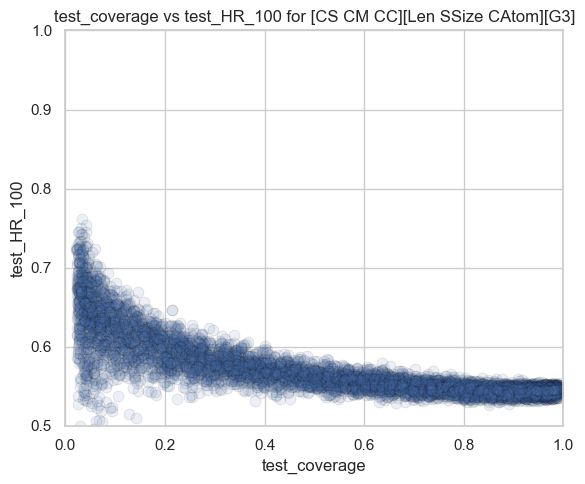

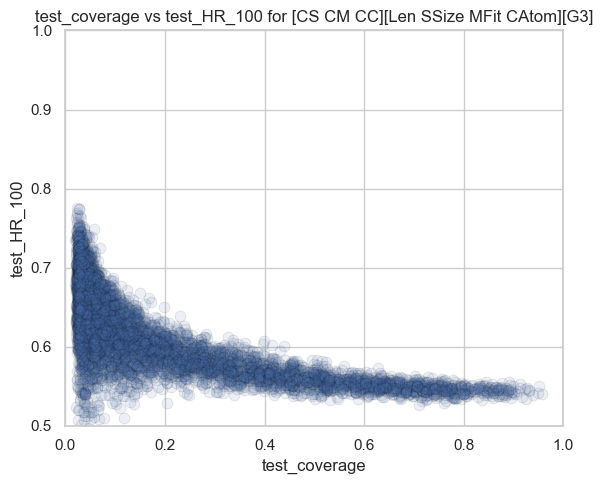

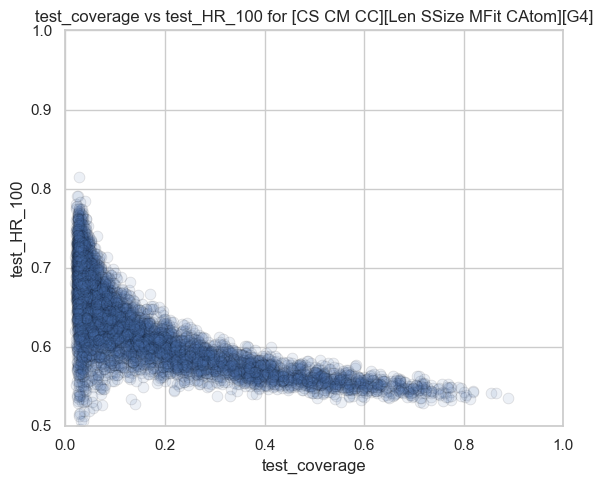

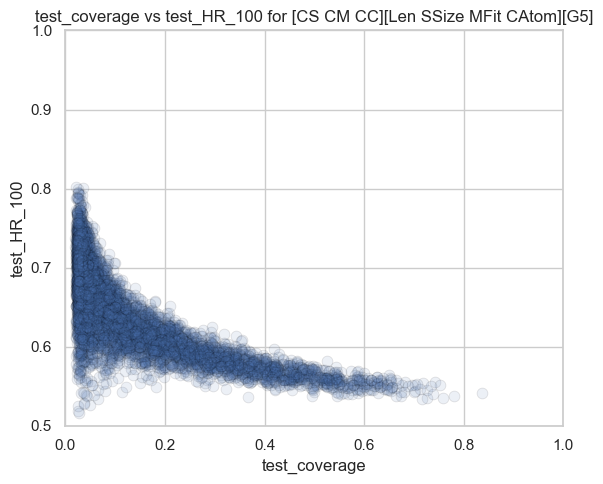

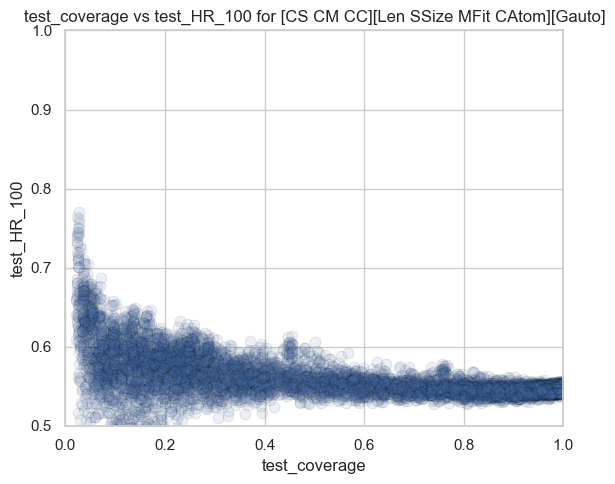

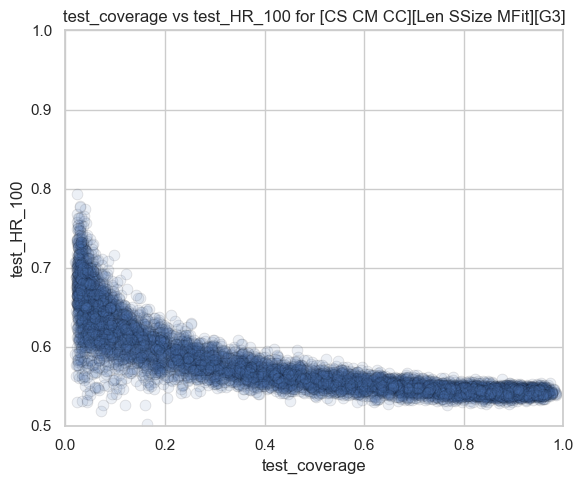

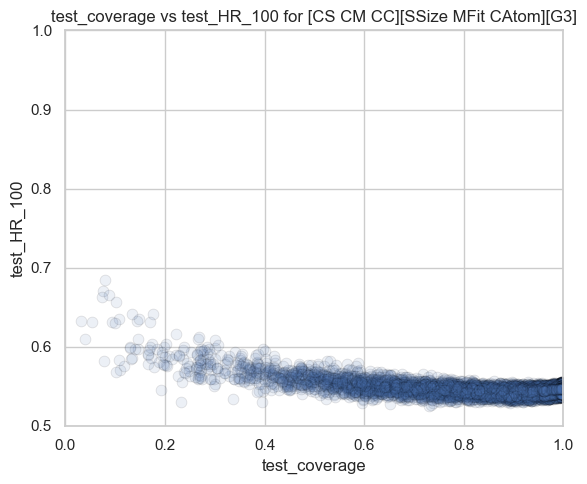

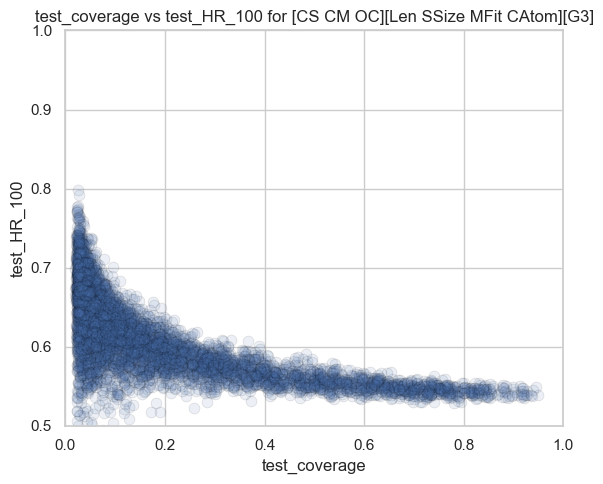

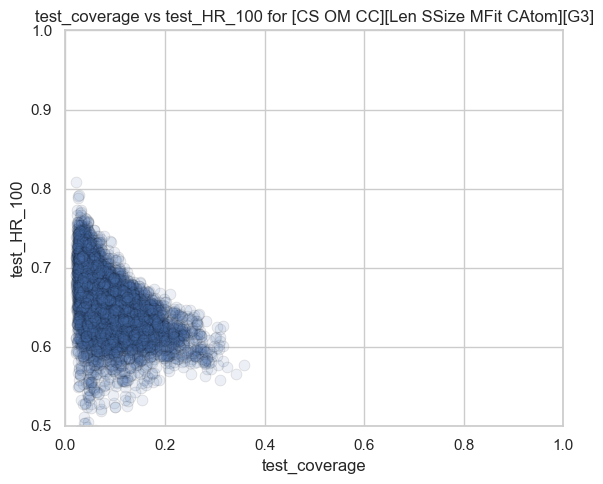

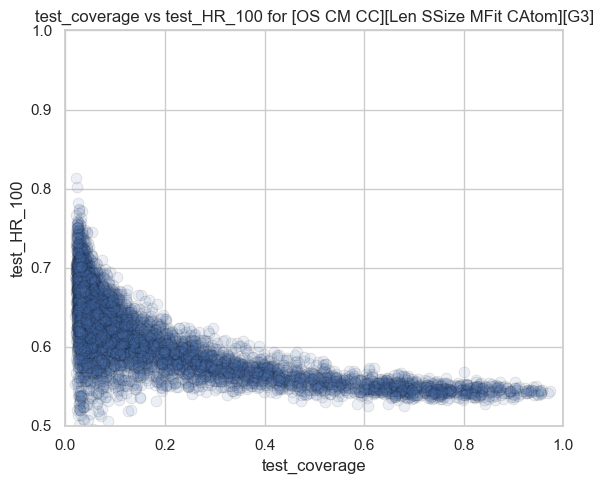

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for consistency
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (6, 5)

for code_name, group_df in results_df.groupby("code_name"):
    plt.figure(figsize=(6, 5))
    sns.scatterplot(
        data=group_df,
        x="test_coverage",
        y="test_HR_100",
        s=60,
        alpha=0.1,
        edgecolor="black"
    )

    plt.title(f"test_coverage vs test_HR_100 for {code_name}")
    plt.xlabel("test_coverage")
    plt.ylabel("test_HR_100")
    plt.xlim(0, 1)
    plt.ylim(0.5, 1)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


* read the data that has been stored as a csv, call it ps_df. 
* the columns of this df are code_name,length,genome_threshold,test_coverage,test_HR_20,test_HR_100,train_coverage,train_HR_20,train_HR_100
* for each codename, find the mean and standard deviation of the length, test_coverage, test_HR_20, test_HR_100, train_coverage,train_HR_20,train_HR_100
* put these results in a table, and save it as a csv where the path will be os.path.join(scratch_processing_dir, "summary_stats_"+utils.get_formatted_timestamp())

In [45]:
import pandas as pd
import os
import utils  # Make sure this is your own module and has get_formatted_timestamp()

scratch_processing_dir = r"C:\Users\gac8\PycharmProjects\PSSearch\retail_forecasting_data_collection\scratch_processing"
data_to_process_path = r"C:\Users\gac8\PycharmProjects\PSSearch\retail_forecasting_data_collection\scratch_processing\temp_processed_all.csv"

if True:
    # Read the data
    ps_df = pd.read_csv(data_to_process_path)  # Replace with actual path
    
    # Define columns to compute stats on
    metrics = [
        "length", "test_coverage", "test_HR_20", "test_HR_100",
        "train_coverage", "train_HR_20", "train_HR_100"
    ]
    
    # Group by 'code_name' and compute mean and std
    grouped = ps_df.groupby("code_name")[metrics].agg(["mean", "std"])
    
    # Flatten MultiIndex columns
    grouped.columns = ['_'.join(col).strip() for col in grouped.columns.values]
    
    # Reset index to make 'code_name' a column again
    summary_df = grouped.reset_index()
    
    # Compute average quantity of items produced (count / 100)  because there's a 100 runs per settings
    counts = ps_df['code_name'].value_counts().sort_index()
    summary_df["avg_quantity"] = counts.values / 100.0
    
    # Save the summary as CSV
    output_path = os.path.join(
        scratch_processing_dir,
        "summary_stats_" + utils.get_formatted_timestamp() + ".csv"
    )
    summary_df.to_csv(output_path, index=False)


In [44]:
import pandas as pd

# Paths to your input CSV files
csv_path_1 = r"C:\Users\gac8\PycharmProjects\PSSearch\retail_forecasting_data_collection\scratch_processing\processed_with_gt.csv"
csv_path_2 = r"C:\Users\gac8\PycharmProjects\PSSearch\retail_forecasting_data_collection\scratch_processing\processed_without_gt.csv"

# Read the CSV files, treating the first column as the index
df1 = pd.read_csv(csv_path_1, index_col=0)
df2 = pd.read_csv(csv_path_2, index_col=0)

# Concatenate the two DataFrames
combined_df = pd.concat([df1, df2], axis=0)

# Optional: reset index if you want a new sequential index
combined_df = combined_df.reset_index(drop=True)

# Save the result
combined_df.to_csv(r"C:\Users\gac8\PycharmProjects\PSSearch\retail_forecasting_data_collection\scratch_processing\temp_processed_all.csv")
